# Week 3: Time Series Analysis for Quantitative Finance

## 🎯 Learning Objectives

By the end of this week, you will understand:
- **Stationarity**: Why it matters and how to test for it
- **Autocorrelation**: Measuring temporal dependencies in data
- **AR, MA, ARIMA Models**: Classical time series forecasting
- **GARCH Models**: Modeling volatility clustering

---

## Why Time Series Analysis?

Financial data is **ordered in time**. Unlike cross-sectional data, we can't shuffle observations randomly - the sequence matters! Time series analysis provides tools to:

1. Identify patterns and dependencies across time
2. Forecast future values
3. Model volatility for risk management
4. Test trading strategy assumptions

In [21]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

print("✅ Libraries loaded successfully!")
print("📚 Week 3: Time Series Analysis")

✅ Libraries loaded successfully!
📚 Week 3: Time Series Analysis


---

# Part 1: Stationarity - The Foundation

## What is Stationarity?

A time series is **stationary** if its statistical properties don't change over time:

| Property | Mathematical Definition |
|----------|------------------------|
| **Constant Mean** | $E[Y_t] = \mu$ for all $t$ |
| **Constant Variance** | $Var(Y_t) = \sigma^2$ for all $t$ |
| **Covariance depends only on lag** | $Cov(Y_t, Y_{t-k}) = \gamma_k$ |

## Why Does Stationarity Matter?

⚠️ **Critical**: Most statistical models ASSUME stationarity!

- Non-stationary data can produce **spurious correlations**
- Model parameters become meaningless if properties change over time
- Forecasts from non-stationary models are unreliable

### Key Insight for Finance:
- **Stock PRICES** → Non-stationary (random walk with drift)
- **Stock RETURNS** → Usually stationary

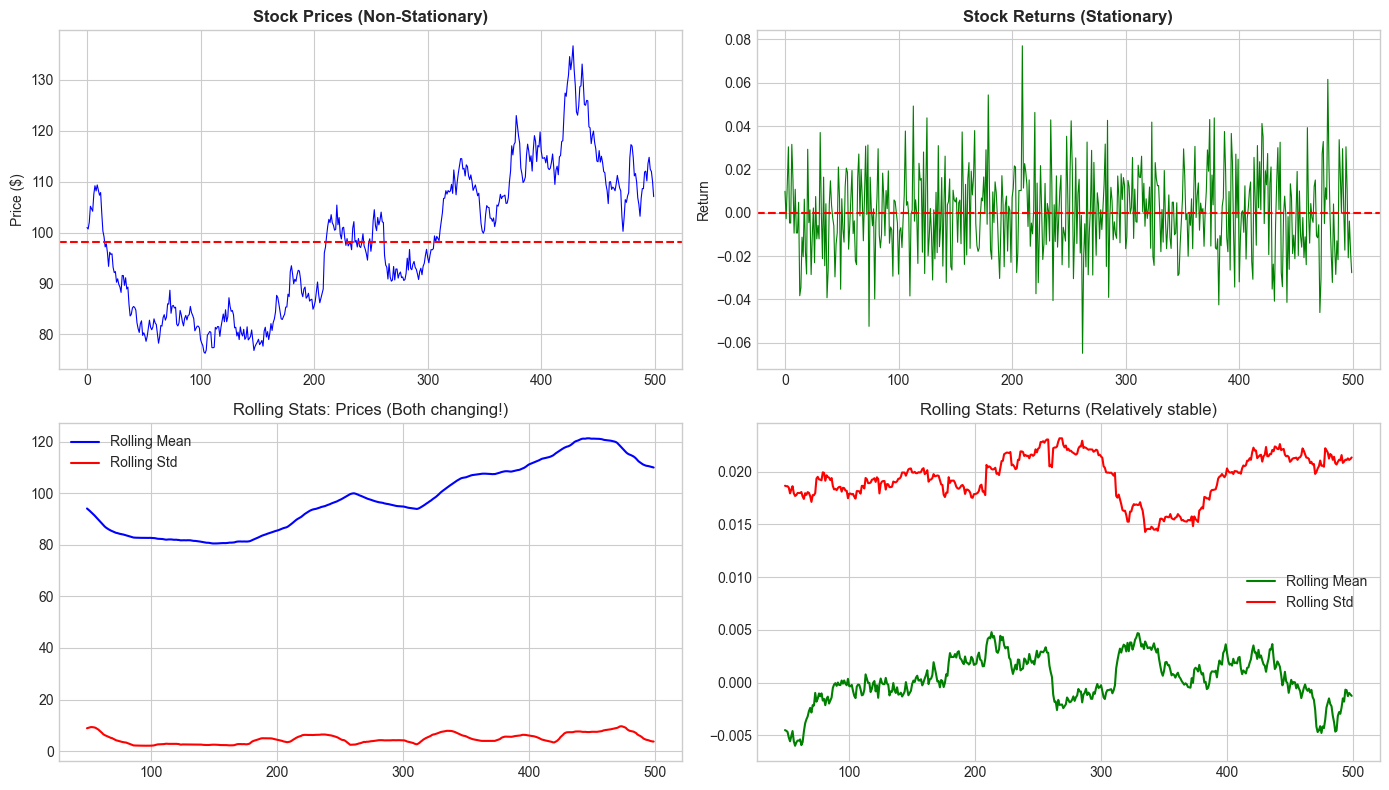


📊 OUTPUT EXPLANATION:
• Top-left: Prices wander randomly - mean changes over time
• Top-right: Returns fluctuate around zero - stable mean
• Bottom-left: Rolling mean/std of prices keep changing
• Bottom-right: Rolling stats of returns stay relatively constant

⚠️  KEY INSIGHT: Always convert prices to returns before modeling!


In [22]:
# Generate example: Stationary vs Non-Stationary series
np.random.seed(42)
n = 500

# Stationary series: Returns (mean-reverting)
stationary = np.random.randn(n) * 0.02  # ~2% daily volatility

# Non-stationary series: Prices (random walk)
non_stationary = 100 * np.exp(np.cumsum(stationary))  # Geometric random walk

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Prices
axes[0, 0].plot(non_stationary, 'b-', linewidth=0.8)
axes[0, 0].set_title('Stock Prices (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].axhline(y=non_stationary.mean(), color='r', linestyle='--', label=f'Mean: ${non_stationary.mean():.2f}')

# Returns
axes[0, 1].plot(stationary, 'g-', linewidth=0.8)
axes[0, 1].set_title('Stock Returns (Stationary)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Return')
axes[0, 1].axhline(y=0, color='r', linestyle='--', label='Mean: 0')

# Rolling statistics - Prices
roll_mean_price = pd.Series(non_stationary).rolling(50).mean()
roll_std_price = pd.Series(non_stationary).rolling(50).std()
axes[1, 0].plot(roll_mean_price, 'b-', label='Rolling Mean')
axes[1, 0].plot(roll_std_price, 'r-', label='Rolling Std')
axes[1, 0].set_title('Rolling Stats: Prices (Both changing!)', fontsize=12)
axes[1, 0].legend()

# Rolling statistics - Returns
roll_mean_ret = pd.Series(stationary).rolling(50).mean()
roll_std_ret = pd.Series(stationary).rolling(50).std()
axes[1, 1].plot(roll_mean_ret, 'g-', label='Rolling Mean')
axes[1, 1].plot(roll_std_ret, 'r-', label='Rolling Std')
axes[1, 1].set_title('Rolling Stats: Returns (Relatively stable)', fontsize=12)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Top-left: Prices wander randomly - mean changes over time")
print("• Top-right: Returns fluctuate around zero - stable mean")
print("• Bottom-left: Rolling mean/std of prices keep changing")
print("• Bottom-right: Rolling stats of returns stay relatively constant")
print("\n⚠️  KEY INSIGHT: Always convert prices to returns before modeling!")

---

## Testing for Stationarity

### 1. Augmented Dickey-Fuller (ADF) Test

**Null Hypothesis (H₀)**: Series has a unit root (non-stationary)

**Test Equation**:
$$\Delta Y_t = \alpha + \beta t + \gamma Y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta Y_{t-i} + \epsilon_t$$

**Decision Rule**:
- p-value < 0.05 → Reject H₀ → **Stationary** ✓
- p-value > 0.05 → Fail to reject → **May have unit root** ✗

### 2. KPSS Test

**Null Hypothesis (H₀)**: Series IS stationary (opposite of ADF!)

**Decision Rule**:
- p-value > 0.05 → Fail to reject → **Stationary** ✓
- p-value < 0.05 → Reject H₀ → **Non-stationary** ✗

### Best Practice: Use BOTH tests together!

In [23]:
def test_stationarity(series, name="Series"):
    """
    Comprehensive stationarity test using ADF and KPSS.
    
    Parameters:
    -----------
    series : array-like
        Time series data to test
    name : str
        Name for display purposes
    
    Returns:
    --------
    dict : Test results
    """
    print(f"\n{'='*60}")
    print(f"STATIONARITY TEST: {name}")
    print(f"{'='*60}")
    
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    adf_stat, adf_pval = adf_result[0], adf_result[1]
    
    print(f"\n📈 ADF Test (H₀: Has unit root = Non-stationary)")
    print(f"   Test Statistic: {adf_stat:.4f}")
    print(f"   p-value: {adf_pval:.4f}")
    print(f"   Critical Values:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.4f}")
    
    adf_conclusion = "STATIONARY ✓" if adf_pval < 0.05 else "NON-STATIONARY ✗"
    print(f"   → Conclusion: {adf_conclusion}")
    
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_stat, kpss_pval = kpss_result[0], kpss_result[1]
    
    print(f"\n📉 KPSS Test (H₀: Is stationary)")
    print(f"   Test Statistic: {kpss_stat:.4f}")
    print(f"   p-value: {kpss_pval:.4f}")
    
    kpss_conclusion = "STATIONARY ✓" if kpss_pval > 0.05 else "NON-STATIONARY ✗"
    print(f"   → Conclusion: {kpss_conclusion}")
    
    # Final verdict
    print(f"\n{'─'*60}")
    if adf_pval < 0.05 and kpss_pval > 0.05:
        verdict = "✅ STATIONARY (Both tests agree)"
    elif adf_pval > 0.05 and kpss_pval < 0.05:
        verdict = "❌ NON-STATIONARY (Both tests agree)"
    else:
        verdict = "⚠️  INCONCLUSIVE (Tests disagree - need more analysis)"
    print(f"FINAL VERDICT: {verdict}")
    
    return {'adf_pval': adf_pval, 'kpss_pval': kpss_pval}

# Test both series
print("\n" + "#"*60)
print("COMPARING STATIONARITY: PRICES VS RETURNS")
print("#"*60)

test_stationarity(non_stationary, "Stock Prices")
test_stationarity(stationary, "Stock Returns")

print("\n\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• ADF test statistic: More negative = stronger evidence for stationarity")
print("• Compare ADF statistic to critical values (1%, 5%, 10% levels)")
print("• If stat < critical value → Reject null → Stationary")
print("• KPSS works opposite: high p-value means stationary")
print("\n💡 TIP: When tests disagree, look at the data visually!")


############################################################
COMPARING STATIONARITY: PRICES VS RETURNS
############################################################

STATIONARITY TEST: Stock Prices

📈 ADF Test (H₀: Has unit root = Non-stationary)
   Test Statistic: -1.5320
   p-value: 0.5176
   Critical Values:
      1%: -3.4435
      5%: -2.8673
      10%: -2.5699
   → Conclusion: NON-STATIONARY ✗

📉 KPSS Test (H₀: Is stationary)
   Test Statistic: 2.8688
   p-value: 0.0100
   → Conclusion: NON-STATIONARY ✗

────────────────────────────────────────────────────────────
FINAL VERDICT: ❌ NON-STATIONARY (Both tests agree)

STATIONARITY TEST: Stock Returns

📈 ADF Test (H₀: Has unit root = Non-stationary)
   Test Statistic: -22.3438
   p-value: 0.0000
   Critical Values:
      1%: -3.4435
      5%: -2.8673
      10%: -2.5699
   → Conclusion: STATIONARY ✓

📉 KPSS Test (H₀: Is stationary)
   Test Statistic: 0.1020
   p-value: 0.1000
   → Conclusion: STATIONARY ✓

─────────────────────────────

---

## Making Series Stationary

### Method 1: Differencing

$$\Delta Y_t = Y_t - Y_{t-1}$$

### Method 2: Log Returns (Most Common in Finance)

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

### Why Log Returns?

| Property | Benefit |
|----------|--------|
| **Time-additive** | $r_{total} = r_1 + r_2 + ... + r_n$ |
| **Symmetric** | +10% and -10% are comparable |
| **Approximately normal** | For daily returns |
| **Stationary** | Mean and variance stable |

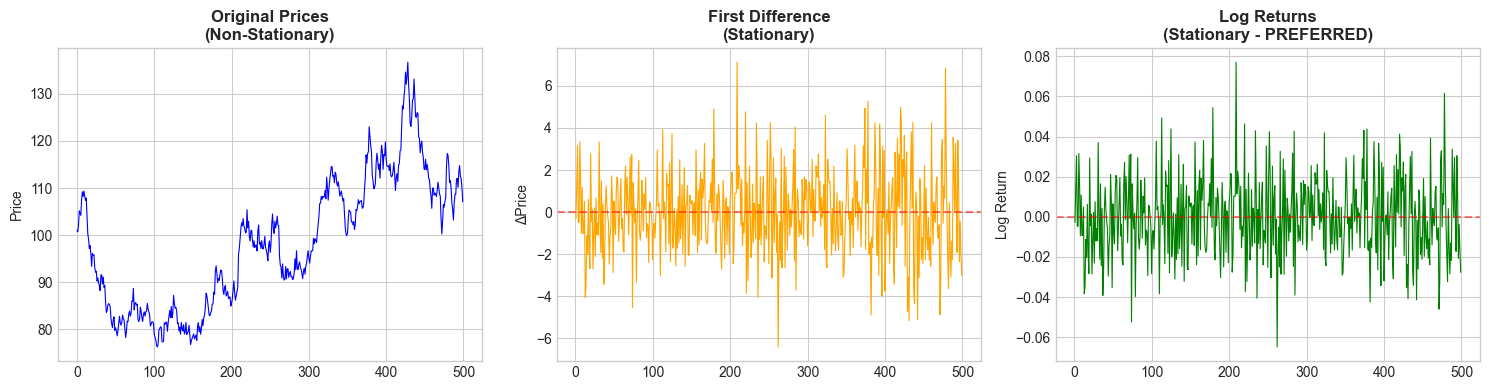


Testing transformed series...

STATIONARITY TEST: Log Returns

📈 ADF Test (H₀: Has unit root = Non-stationary)
   Test Statistic: -22.3130
   p-value: 0.0000
   Critical Values:
      1%: -3.4435
      5%: -2.8674
      10%: -2.5699
   → Conclusion: STATIONARY ✓

📉 KPSS Test (H₀: Is stationary)
   Test Statistic: 0.1078
   p-value: 0.1000
   → Conclusion: STATIONARY ✓

────────────────────────────────────────────────────────────
FINAL VERDICT: ✅ STATIONARY (Both tests agree)

📊 OUTPUT EXPLANATION:
• Differencing removes the trend component
• Log returns are preferred because:
  1. Scale-independent (can compare across stocks)
  2. Time-additive (weekly return = sum of daily returns)
  3. More symmetric for gains/losses


In [24]:
# Demonstrate transformation to stationarity
prices = pd.Series(non_stationary)

# Method 1: Simple differencing
diff_prices = prices.diff().dropna()

# Method 2: Log returns
log_returns = np.log(prices).diff().dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(prices, 'b-', linewidth=0.8)
axes[0].set_title('Original Prices\n(Non-Stationary)', fontweight='bold')
axes[0].set_ylabel('Price')

axes[1].plot(diff_prices, 'orange', linewidth=0.8)
axes[1].set_title('First Difference\n(Stationary)', fontweight='bold')
axes[1].set_ylabel('ΔPrice')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

axes[2].plot(log_returns, 'g-', linewidth=0.8)
axes[2].set_title('Log Returns\n(Stationary - PREFERRED)', fontweight='bold')
axes[2].set_ylabel('Log Return')
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Test the transformed series
print("\nTesting transformed series...")
test_stationarity(log_returns, "Log Returns")

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Differencing removes the trend component")
print("• Log returns are preferred because:")
print("  1. Scale-independent (can compare across stocks)")
print("  2. Time-additive (weekly return = sum of daily returns)")
print("  3. More symmetric for gains/losses")

---

# Part 2: Autocorrelation - Temporal Dependencies

## Autocorrelation Function (ACF)

Measures correlation between $Y_t$ and $Y_{t-k}$ at lag $k$:

$$\rho_k = \frac{Cov(Y_t, Y_{t-k})}{Var(Y_t)} = \frac{E[(Y_t - \mu)(Y_{t-k} - \mu)]}{\sigma^2}$$

**Properties**:
- $\rho_0 = 1$ (series perfectly correlated with itself)
- $-1 \leq \rho_k \leq 1$
- For stationary series, $\rho_k \to 0$ as $k \to \infty$

## Partial Autocorrelation Function (PACF)

Measures **direct** correlation between $Y_t$ and $Y_{t-k}$ after removing intermediate effects.

**Intuition**: 
- ACF at lag 2 = direct effect + indirect effect through lag 1
- PACF at lag 2 = only direct effect

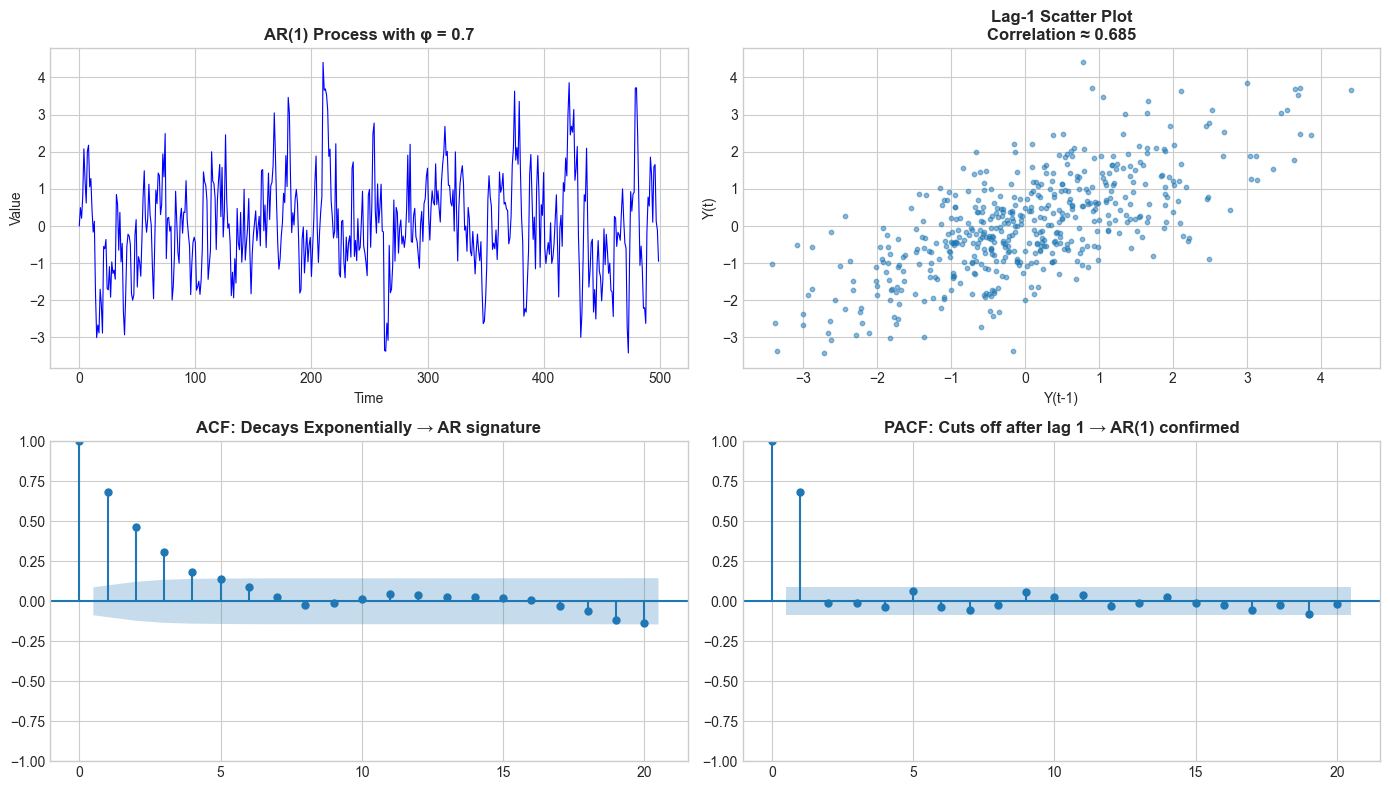


📊 OUTPUT EXPLANATION:
• AR(1) with φ=0.7 means each value is 70% of previous + noise
• Scatter plot shows strong positive correlation at lag 1
• ACF decays exponentially: φ^k pattern (0.7, 0.49, 0.34, ...)
• PACF cuts off after lag 1: Only direct effect at lag 1

🔑 KEY PATTERN:
   ACF decays + PACF cuts off = AR(p) model
   ACF cuts off + PACF decays = MA(q) model


In [25]:
# Generate AR(1) process to demonstrate ACF/PACF patterns
np.random.seed(42)
n = 500
phi = 0.7  # AR coefficient

# AR(1): Y_t = phi * Y_{t-1} + epsilon_t
ar1_process = np.zeros(n)
for t in range(1, n):
    ar1_process[t] = phi * ar1_process[t-1] + np.random.randn()

# Plot the series and ACF/PACF
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time series
axes[0, 0].plot(ar1_process, 'b-', linewidth=0.8)
axes[0, 0].set_title(f'AR(1) Process with φ = {phi}', fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')

# Scatter plot Y_t vs Y_{t-1}
axes[0, 1].scatter(ar1_process[:-1], ar1_process[1:], alpha=0.5, s=10)
axes[0, 1].set_xlabel('Y(t-1)')
axes[0, 1].set_ylabel('Y(t)')
axes[0, 1].set_title(f'Lag-1 Scatter Plot\nCorrelation ≈ {np.corrcoef(ar1_process[:-1], ar1_process[1:])[0,1]:.3f}', fontweight='bold')

# ACF
plot_acf(ar1_process, lags=20, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF: Decays Exponentially → AR signature', fontweight='bold')

# PACF
plot_pacf(ar1_process, lags=20, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('PACF: Cuts off after lag 1 → AR(1) confirmed', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print(f"• AR(1) with φ={phi} means each value is {phi*100:.0f}% of previous + noise")
print("• Scatter plot shows strong positive correlation at lag 1")
print("• ACF decays exponentially: φ^k pattern (0.7, 0.49, 0.34, ...)")
print("• PACF cuts off after lag 1: Only direct effect at lag 1")
print("\n🔑 KEY PATTERN:")
print("   ACF decays + PACF cuts off = AR(p) model")
print("   ACF cuts off + PACF decays = MA(q) model")

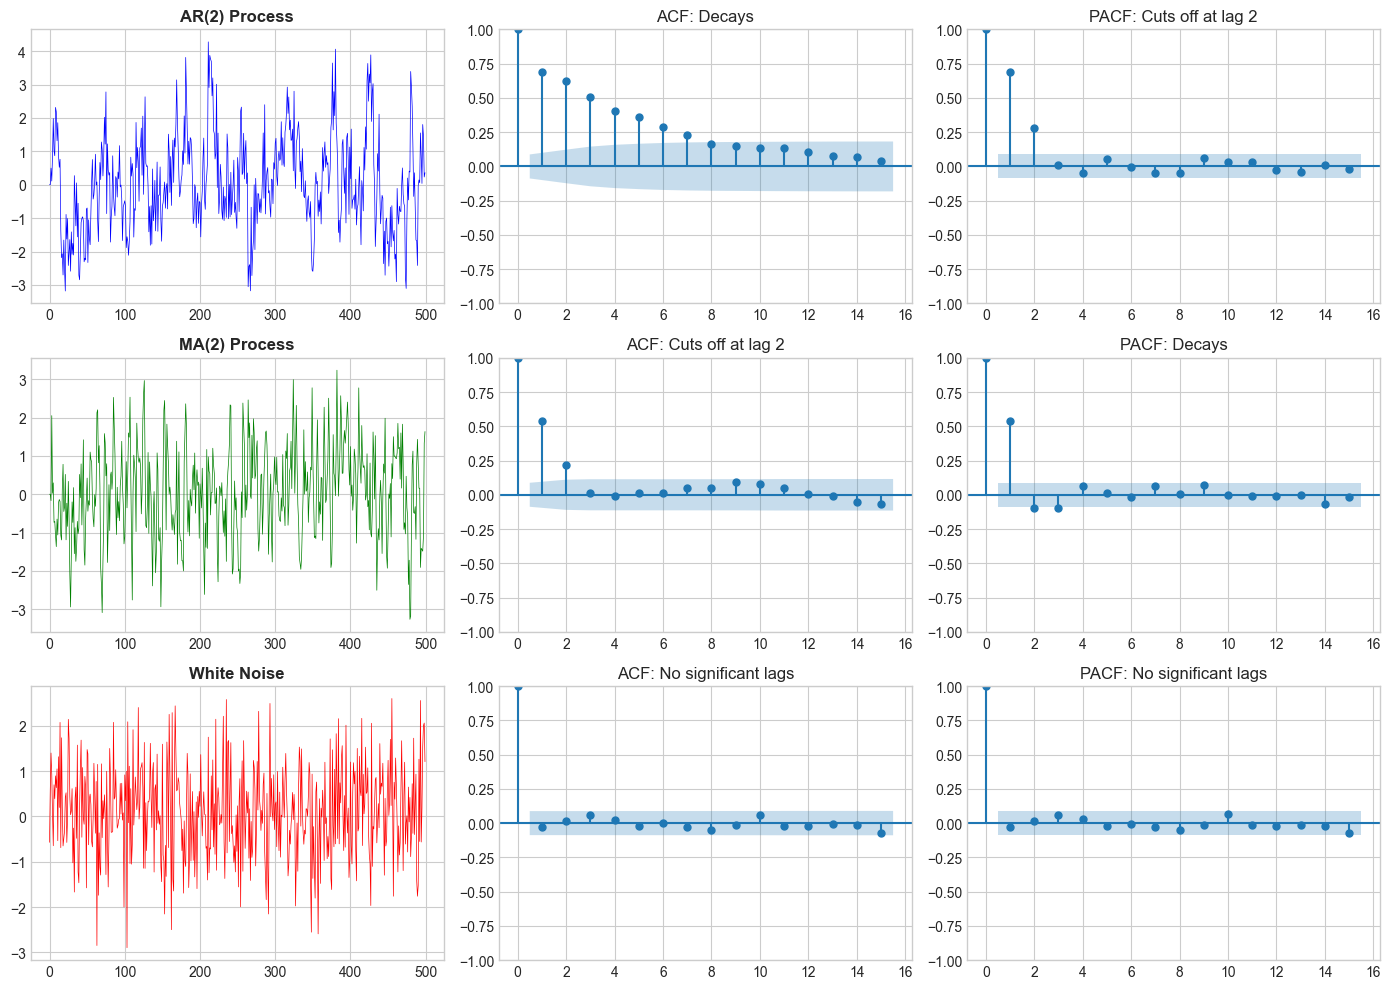


📊 ACF/PACF PATTERN SUMMARY:

| Model      | ACF Pattern          | PACF Pattern         |
|------------|---------------------|---------------------|
| AR(p)      | Decays exponentially | Cuts off after lag p |
| MA(q)      | Cuts off after lag q | Decays exponentially |
| ARMA(p,q)  | Decays               | Decays               |
| White Noise| All ~0               | All ~0               |

🔵 Blue shaded area = 95% confidence interval
📌 Bars outside shaded area = Statistically significant


In [26]:
# Compare ACF/PACF patterns for different models
np.random.seed(42)
n = 500

# AR(2) process
ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = 0.5*ar2[t-1] + 0.3*ar2[t-2] + np.random.randn()

# MA(2) process
noise = np.random.randn(n)
ma2 = np.zeros(n)
for t in range(2, n):
    ma2[t] = noise[t] + 0.6*noise[t-1] + 0.3*noise[t-2]

# White noise (no correlation)
white_noise = np.random.randn(n)

fig, axes = plt.subplots(3, 3, figsize=(14, 10))

# Row 1: AR(2)
axes[0, 0].plot(ar2, 'b-', linewidth=0.5)
axes[0, 0].set_title('AR(2) Process', fontweight='bold')
plot_acf(ar2, lags=15, ax=axes[0, 1], title='ACF: Decays')
plot_pacf(ar2, lags=15, ax=axes[0, 2], title='PACF: Cuts off at lag 2')

# Row 2: MA(2)
axes[1, 0].plot(ma2, 'g-', linewidth=0.5)
axes[1, 0].set_title('MA(2) Process', fontweight='bold')
plot_acf(ma2, lags=15, ax=axes[1, 1], title='ACF: Cuts off at lag 2')
plot_pacf(ma2, lags=15, ax=axes[1, 2], title='PACF: Decays')

# Row 3: White Noise
axes[2, 0].plot(white_noise, 'r-', linewidth=0.5)
axes[2, 0].set_title('White Noise', fontweight='bold')
plot_acf(white_noise, lags=15, ax=axes[2, 1], title='ACF: No significant lags')
plot_pacf(white_noise, lags=15, ax=axes[2, 2], title='PACF: No significant lags')

plt.tight_layout()
plt.show()

print("\n📊 ACF/PACF PATTERN SUMMARY:")
print("="*60)
print("")
print("| Model      | ACF Pattern          | PACF Pattern         |")
print("|------------|---------------------|---------------------|")
print("| AR(p)      | Decays exponentially | Cuts off after lag p |")
print("| MA(q)      | Cuts off after lag q | Decays exponentially |")
print("| ARMA(p,q)  | Decays               | Decays               |")
print("| White Noise| All ~0               | All ~0               |")
print("")
print("🔵 Blue shaded area = 95% confidence interval")
print("📌 Bars outside shaded area = Statistically significant")

---

# Part 3: ARIMA Models

## AR(p) - Autoregressive Model

$$Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \epsilon_t$$

**Interpretation**: Current value depends on past values

## MA(q) - Moving Average Model

$$Y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$$

**Interpretation**: Current value depends on past errors/shocks

## ARIMA(p, d, q)

Combines AR, Differencing, and MA:
- **p**: AR order (lagged values)
- **d**: Differencing order (usually 0 or 1)
- **q**: MA order (lagged errors)

### Model Selection: Information Criteria

**AIC** (Akaike): $AIC = 2k - 2\ln(\hat{L})$

**BIC** (Bayesian): $BIC = k\ln(n) - 2\ln(\hat{L})$

**Rule**: Lower is better. BIC penalizes complexity more than AIC.

In [27]:
# Fit ARIMA models to real-looking financial data
np.random.seed(42)

# Simulate returns with some structure
n = 500
returns = np.zeros(n)
for t in range(1, n):
    returns[t] = 0.0002 + 0.1*returns[t-1] + np.random.randn()*0.01 + 0.05*np.random.randn()*0.01

returns_series = pd.Series(returns, index=pd.date_range('2020-01-01', periods=n, freq='D'))

# Try different ARIMA specifications
models_to_try = [
    (0, 0, 0),  # No structure
    (1, 0, 0),  # AR(1)
    (0, 0, 1),  # MA(1)
    (1, 0, 1),  # ARMA(1,1)
    (2, 0, 1),  # ARMA(2,1)
]

print("MODEL COMPARISON: Finding Best ARIMA Specification")
print("="*60)
print(f"{'Model':<15} {'AIC':>12} {'BIC':>12} {'Log-Lik':>12}")
print("-"*60)

results_dict = {}
for order in models_to_try:
    try:
        model = ARIMA(returns_series, order=order)
        result = model.fit()
        results_dict[order] = result
        order_str = str(order)
        print(f"ARIMA{order_str:<12} {result.aic:>12.2f} {result.bic:>12.2f} {result.llf:>12.2f}")
    except Exception as e:
        order_str = str(order)
        print(f"ARIMA{order_str:<12} Failed: {e}")

# Find best model by AIC
best_order = min(results_dict, key=lambda x: results_dict[x].aic)
best_model = results_dict[best_order]

print("-"*60)
print(f"\n✅ BEST MODEL (lowest AIC): ARIMA{best_order}")

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• AIC/BIC: Lower = better fit with appropriate complexity penalty")
print("• Log-Likelihood: Higher = better fit (no penalty)")
print("• AIC = 2k - 2*LogLik (k = number of parameters)")
print("• BIC = k*ln(n) - 2*LogLik (stronger penalty for complexity)")
print("\n💡 TIP: BIC often selects simpler models than AIC")

MODEL COMPARISON: Finding Best ARIMA Specification
Model                    AIC          BIC      Log-Lik
------------------------------------------------------------
ARIMA(0, 0, 0)        -3212.69     -3204.26      1608.35
ARIMA(1, 0, 0)        -3215.12     -3202.48      1610.56
ARIMA(0, 0, 1)        -3215.30     -3202.65      1610.65
ARIMA(1, 0, 1)        -3213.31     -3196.45      1610.65
ARIMA(2, 0, 1)        -3211.49     -3190.41      1610.74
------------------------------------------------------------

✅ BEST MODEL (lowest AIC): ARIMA(0, 0, 1)

📊 OUTPUT EXPLANATION:
• AIC/BIC: Lower = better fit with appropriate complexity penalty
• Log-Likelihood: Higher = better fit (no penalty)
• AIC = 2k - 2*LogLik (k = number of parameters)
• BIC = k*ln(n) - 2*LogLik (stronger penalty for complexity)

💡 TIP: BIC often selects simpler models than AIC



DETAILED MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1610.649
Date:                Wed, 21 Jan 2026   AIC                          -3215.297
Time:                        18:27:08   BIC                          -3202.653
Sample:                    01-01-2020   HQIC                         -3210.336
                         - 05-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.611      0.541      -0.001       0.001
ma.L1          0.0946      0.048      1.962      0.050    8.75e-05       0.189
sigma2      9.319e-05   5.56

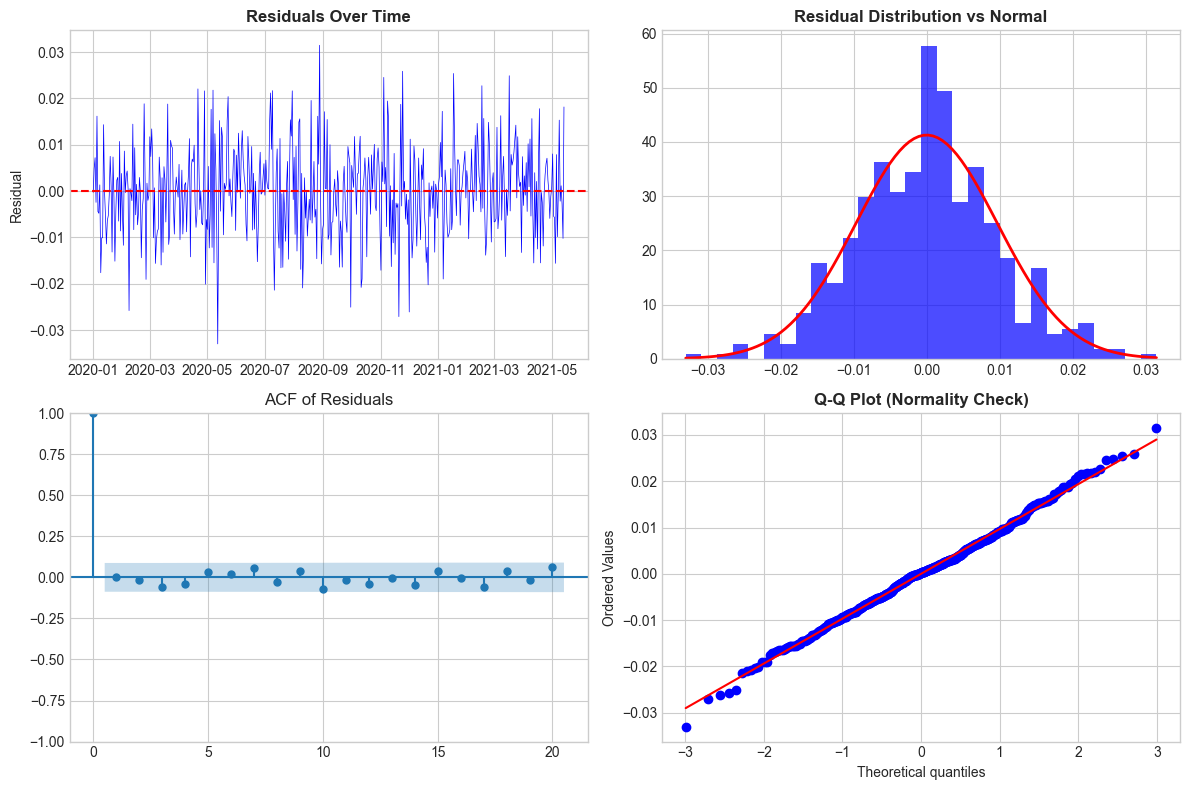


📊 DIAGNOSTIC INTERPRETATION:
✓ Residuals should look like white noise (random, no pattern)
✓ ACF of residuals should have no significant lags
✓ Histogram should approximate normal distribution
✓ Q-Q plot points should follow diagonal line

⚠️  If diagnostics fail, try different model order!


In [28]:
# Detailed analysis of best model
print("\nDETAILED MODEL SUMMARY")
print("="*60)
print(best_model.summary())

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

residuals = best_model.resid

# Residuals over time
axes[0, 0].plot(residuals, 'b-', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
axes[0, 0].set_ylabel('Residual')

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, density=True, alpha=0.7, color='blue')
x = np.linspace(residuals.min(), residuals.max(), 100)
from scipy.stats import norm
axes[0, 1].plot(x, norm.pdf(x, residuals.mean(), residuals.std()), 'r-', linewidth=2)
axes[0, 1].set_title('Residual Distribution vs Normal', fontweight='bold')

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 0], title='ACF of Residuals')

# Q-Q plot
from scipy.stats import probplot
probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 DIAGNOSTIC INTERPRETATION:")
print("="*60)
print("✓ Residuals should look like white noise (random, no pattern)")
print("✓ ACF of residuals should have no significant lags")
print("✓ Histogram should approximate normal distribution")
print("✓ Q-Q plot points should follow diagonal line")
print("\n⚠️  If diagnostics fail, try different model order!")

---

# Part 4: Volatility Modeling with GARCH

## The Problem: Volatility Clustering

Financial returns exhibit **volatility clustering**: large changes tend to be followed by large changes.

ARIMA assumes constant variance, but financial data shows:
- Periods of high volatility
- Periods of low volatility
- Volatility is predictable!

## GARCH(1,1) Model

**Generalized Autoregressive Conditional Heteroskedasticity**

$$r_t = \mu + \epsilon_t, \quad \epsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where:
- $\omega > 0$: Base/long-run variance component
- $\alpha \geq 0$: Reaction to recent shocks (ARCH term)
- $\beta \geq 0$: Persistence of past variance (GARCH term)
- $\alpha + \beta < 1$: Stationarity condition

### Key Quantities

**Long-run variance**: $\bar{\sigma}^2 = \frac{\omega}{1 - \alpha - \beta}$

**Persistence**: $\alpha + \beta$ (how long shocks affect volatility)

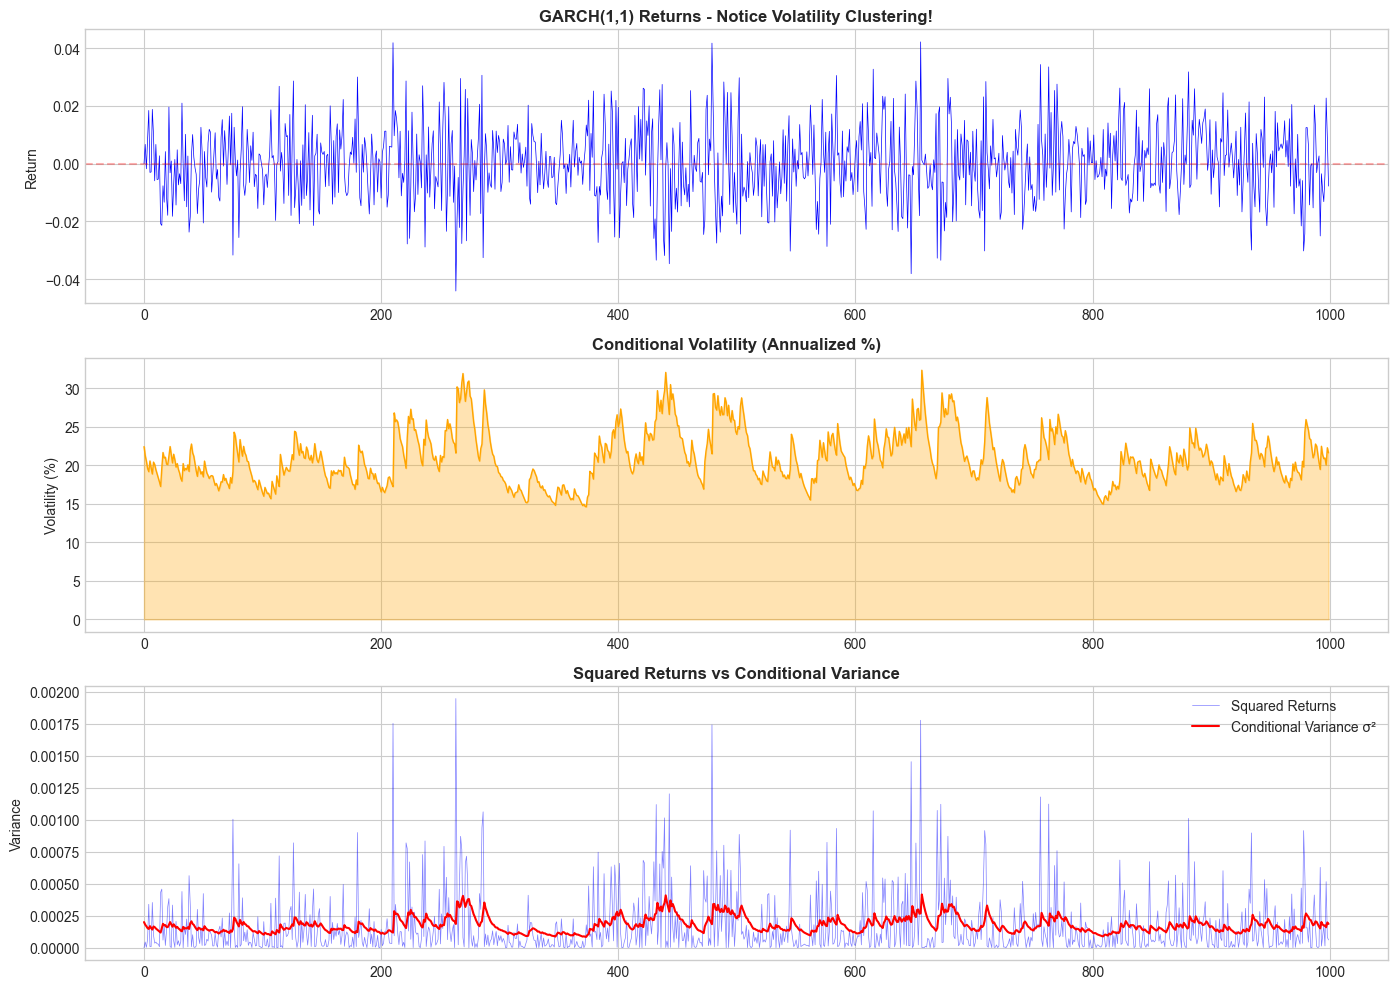


📊 OUTPUT EXPLANATION:
• Top: Returns cluster in volatile/calm periods
• Middle: Volatility is TIME-VARYING and predictable
• Bottom: Conditional variance tracks squared returns closely

🔢 GARCH Parameters: ω=1e-05, α=0.1, β=0.85
   Persistence (α+β) = 0.95
   Long-run vol = 22.4% annually


In [29]:
# Demonstrate volatility clustering
np.random.seed(42)
n = 1000

# Simulate GARCH(1,1) process
omega = 0.00001  # Base variance
alpha = 0.1       # Reaction to shocks
beta = 0.85       # Persistence

returns_garch = np.zeros(n)
sigma2 = np.zeros(n)
sigma2[0] = omega / (1 - alpha - beta)  # Start at unconditional variance

for t in range(1, n):
    sigma2[t] = omega + alpha * returns_garch[t-1]**2 + beta * sigma2[t-1]
    returns_garch[t] = np.sqrt(sigma2[t]) * np.random.randn()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Returns
axes[0].plot(returns_garch, 'b-', linewidth=0.5)
axes[0].set_title('GARCH(1,1) Returns - Notice Volatility Clustering!', fontweight='bold')
axes[0].set_ylabel('Return')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Conditional volatility
axes[1].plot(np.sqrt(sigma2)*np.sqrt(252)*100, 'orange', linewidth=1)
axes[1].set_title('Conditional Volatility (Annualized %)', fontweight='bold')
axes[1].set_ylabel('Volatility (%)')
axes[1].fill_between(range(n), 0, np.sqrt(sigma2)*np.sqrt(252)*100, alpha=0.3, color='orange')

# Squared returns vs conditional variance
axes[2].plot(returns_garch**2, 'b-', linewidth=0.5, alpha=0.5, label='Squared Returns')
axes[2].plot(sigma2, 'r-', linewidth=1.5, label='Conditional Variance σ²')
axes[2].set_title('Squared Returns vs Conditional Variance', fontweight='bold')
axes[2].set_ylabel('Variance')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n📊 OUTPUT EXPLANATION:")
print("="*60)
print("• Top: Returns cluster in volatile/calm periods")
print("• Middle: Volatility is TIME-VARYING and predictable")
print("• Bottom: Conditional variance tracks squared returns closely")
print(f"\n🔢 GARCH Parameters: ω={omega}, α={alpha}, β={beta}")
print(f"   Persistence (α+β) = {alpha+beta:.2f}")
print(f"   Long-run vol = {np.sqrt(omega/(1-alpha-beta))*np.sqrt(252)*100:.1f}% annually")

In [30]:
# Fit GARCH model using arch library
returns_scaled = returns_garch * 100  # Scale for numerical stability

# Fit GARCH(1,1)
garch_model = arch_model(returns_scaled, vol='Garch', p=1, q=1, mean='Constant')
garch_result = garch_model.fit(disp='off')

print("GARCH(1,1) MODEL RESULTS")
print("="*60)
print(garch_result.summary())

# Extract parameters
params = garch_result.params
omega_hat = params['omega']
alpha_hat = params['alpha[1]']
beta_hat = params['beta[1]']

print("\n" + "="*60)
print("PARAMETER INTERPRETATION")
print("="*60)
print(f"\nω (omega) = {omega_hat:.6f}")
print(f"   → Base variance level")
print(f"\nα (alpha) = {alpha_hat:.4f}")
print(f"   → Reaction to recent shocks")
print(f"   → Higher α = more reactive to news")
print(f"\nβ (beta) = {beta_hat:.4f}")
print(f"   → Persistence of volatility")
print(f"   → Higher β = volatility decays slowly")
print(f"\nPersistence (α+β) = {alpha_hat + beta_hat:.4f}")
if alpha_hat + beta_hat < 1:
    print(f"   → < 1: Volatility is mean-reverting ✓")
    long_run_var = omega_hat / (1 - alpha_hat - beta_hat)
    print(f"   → Long-run volatility: {np.sqrt(long_run_var)*np.sqrt(252):.2f}% annually")
else:
    print(f"   → ≥ 1: Integrated volatility (IGARCH)")

GARCH(1,1) MODEL RESULTS
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1658.65
Distribution:                  Normal   AIC:                           3325.30
Method:            Maximum Likelihood   BIC:                           3344.93
                                        No. Observations:                 1000
Date:                Wed, Jan 21 2026   Df Residuals:                      999
Time:                        18:27:09   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0283  3.874e-02    

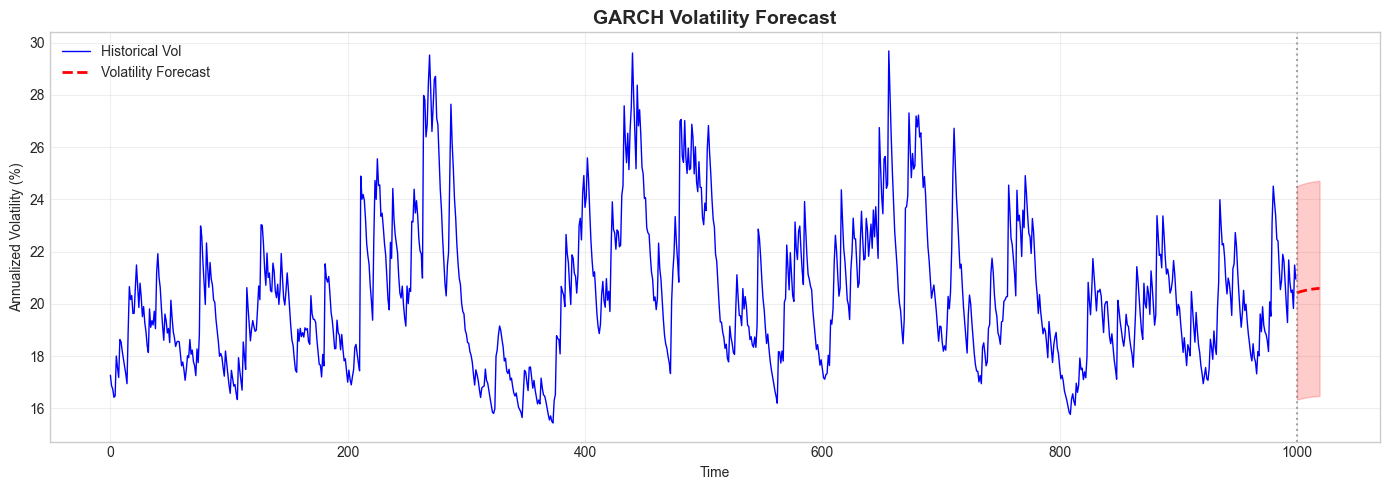


📊 VOLATILITY FORECAST:
Current volatility: 20.94%

Forecast for next 20 periods:
   Day 1:  20.42%
   Day 5:  20.48%
   Day 10: 20.53%
   Day 20: 20.59%

💡 Notice: Volatility forecasts converge to long-run mean!


In [31]:
# Volatility forecasting with GARCH
forecast_horizon = 20

# Forecast volatility
forecast = garch_result.forecast(horizon=forecast_horizon)
forecast_variance = forecast.variance.iloc[-1].values
forecast_vol = np.sqrt(forecast_variance) * np.sqrt(252)  # Annualized

# Historical conditional volatility
cond_vol = garch_result.conditional_volatility * np.sqrt(252)
cond_vol_values = np.array(cond_vol)  # Convert to numpy array for compatibility

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

# Historical
ax.plot(range(len(cond_vol_values)), cond_vol_values, 'b-', linewidth=1, label='Historical Vol')

# Forecast
forecast_x = range(len(cond_vol_values), len(cond_vol_values) + forecast_horizon)
ax.plot(forecast_x, forecast_vol, 'r--', linewidth=2, label='Volatility Forecast')
ax.fill_between(forecast_x, forecast_vol*0.8, forecast_vol*1.2, alpha=0.2, color='red')

ax.axvline(x=len(cond_vol_values), color='gray', linestyle=':', alpha=0.7)
ax.set_title('GARCH Volatility Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Annualized Volatility (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 VOLATILITY FORECAST:")
print("="*60)
print(f"Current volatility: {cond_vol_values[-1]:.2f}%")
print(f"\nForecast for next {forecast_horizon} periods:")
print(f"   Day 1:  {forecast_vol[0]:.2f}%")
print(f"   Day 5:  {forecast_vol[4]:.2f}%")
print(f"   Day 10: {forecast_vol[9]:.2f}%")
print(f"   Day 20: {forecast_vol[19]:.2f}%")
print("\n💡 Notice: Volatility forecasts converge to long-run mean!")

---

# Summary: Key Formulas & Concepts

## Quick Reference Table

| Concept | Formula | Use Case |
|---------|---------|----------|
| **Log Return** | $r_t = \ln(P_t/P_{t-1})$ | Transform prices to stationary series |
| **ACF** | $\rho_k = Cov(Y_t, Y_{t-k})/Var(Y_t)$ | Identify MA order |
| **AR(1)** | $Y_t = c + \phi Y_{t-1} + \epsilon_t$ | Mean-reverting series |
| **MA(1)** | $Y_t = \mu + \epsilon_t + \theta\epsilon_{t-1}$ | Short-lived shocks |
| **GARCH(1,1)** | $\sigma_t^2 = \omega + \alpha\epsilon_{t-1}^2 + \beta\sigma_{t-1}^2$ | Volatility clustering |
| **Half-life** | $t_{1/2} = -\ln(2)/\ln(\phi)$ | Mean reversion speed |
| **ADF Test** | H₀: Unit root (non-stationary) | Test stationarity |

## Common Interview Questions

1. **Why use log returns instead of simple returns?**
   - Time-additive, approximately normal, symmetric

2. **How do you check if a series is stationary?**
   - Use ADF and KPSS tests together

3. **What does GARCH capture that ARIMA doesn't?**
   - Time-varying volatility (volatility clustering)

4. **What's the persistence in GARCH?**
   - α + β: How long shocks affect volatility

In [32]:
# Final summary
print("""
╔══════════════════════════════════════════════════════════════════╗
║           WEEK 3 COMPLETE: TIME SERIES ANALYSIS                  ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✓ Part 1: Stationarity                                         ║
║    • Understood why stationarity matters                        ║
║    • Learned ADF and KPSS tests                                 ║
║    • Converted prices to returns                                ║
║                                                                  ║
║  ✓ Part 2: Autocorrelation                                      ║
║    • Computed and interpreted ACF/PACF                          ║
║    • Identified AR vs MA patterns                               ║
║                                                                  ║
║  ✓ Part 3: ARIMA Models                                         ║
║    • Fit AR, MA, and ARMA models                                ║
║    • Used AIC/BIC for model selection                           ║
║    • Checked residual diagnostics                               ║
║                                                                  ║
║  ✓ Part 4: GARCH Volatility                                     ║
║    • Understood volatility clustering                           ║
║    • Fit GARCH(1,1) model                                       ║
║    • Forecasted future volatility                               ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝

🎯 Next Week: Financial Data & Portfolio Theory
""")


╔══════════════════════════════════════════════════════════════════╗
║           WEEK 3 COMPLETE: TIME SERIES ANALYSIS                  ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ✓ Part 1: Stationarity                                         ║
║    • Understood why stationarity matters                        ║
║    • Learned ADF and KPSS tests                                 ║
║    • Converted prices to returns                                ║
║                                                                  ║
║  ✓ Part 2: Autocorrelation                                      ║
║    • Computed and interpreted ACF/PACF                          ║
║    • Identified AR vs MA patterns                               ║
║                                                                  ║
║  ✓ Part 3: ARIMA Models                                         ║
║    • Fit AR, MA, and ARMA models       